In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

### Get and explore data
Dataset - https://www.kaggle.com/grouplens/movielens-20m-dataset

In [2]:
df = pd.read_csv('C:/N/UCU/1_sem_2020/linear algebra/final project/data/MovieLens/rating.csv')
df = df.head(100000)
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
df['userId'] = df['userId'].astype('str')
df['movieId'] = df['movieId'].astype('str')
#list of all users and movies
users = df['userId'].unique() 
movies = df['movieId'].unique() 
print("Number of users", len(users))
print("Number of movies", len(movies))
print(df.head())

Number of users 702
Number of movies 8227
  userId movieId  rating            timestamp
0      1       2     3.5  2005-04-02 23:53:47
1      1      29     3.5  2005-04-02 23:31:16
2      1      32     3.5  2005-04-02 23:33:39
3      1      47     3.5  2005-04-02 23:32:07
4      1      50     3.5  2005-04-02 23:29:40


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100000 non-null  object 
 1   movieId    100000 non-null  object 
 2   rating     100000 non-null  float64
 3   timestamp  100000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.1+ MB


NameError: name 'plt' is not defined

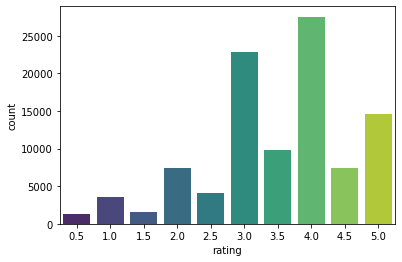

In [5]:
sns.countplot(x=df['rating'], data=df, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [6]:
# Find mean ratings for movies:
mean_rating = df['rating'].mean()
mean_rating

3.507605

### Train and Test split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

In [12]:
train = pd.DataFrame(columns=df.columns)
test = pd.DataFrame(columns=df.columns)

#20 percent of the dataset will be allocated to the test set and 80 percent will be allocated to the training set
test_per = 0.2 

for x in users:
    temp = df[df['userId'] == x]
    n = len(temp)
    test_size = int(test_per*n)

#take latest data about rating for a test (not a random split)
temp = temp.sort_values('timestamp').reset_index()
temp.drop('index', axis=1, inplace=True)
    
dummy_train = temp.loc[: n-2-test_size]
dummy_test = temp.loc[n-1-test_size :]

train = pd.concat([train, dummy_train])    
test = pd.concat([test, dummy_test])


### Create Utility Matrix 1.0 (n x m), n=users, m=items

In [ ]:
from scipy.linalg import sqrtm

We create a corpus that keep a key-value pairs for each column. 
Utility Matrix is  a 2D matrix where one axis belongs to the users and the other axis belongs to the movies. So the value at (i,j) location of the matrix will be the rating that user i gave for movie j.

In [ ]:
#we transform the column userId to column 0 for the key ‘user’, column movieId to column 1 for key ‘item’ 
#and column ratings to column 2 for key ‘value’.
def create_X0_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
     
    itemField = formatizer['item']
    userField = formatizer['user']
    valueField = formatizer['value']
    
    userList = data.loc[:,userField].tolist()
    itemList = data.loc[:,itemField].tolist()
    valueList = data.loc[:,valueField].tolist()
    
    users = list(set(data.loc[:,userField]))
    items = list(set(data.loc[:,itemField]))
    users_index = {users[i]: i for i in range(len(users))}
    
    pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    for i in range(0,len(data)):
        item = itemList[i]
        user = userList[i]
        value = valueList[i]
    pd_dict[item][users_index[user]] = value
    X0 = pd.DataFrame(pd_dict)
    X0.index = users
        
    itemcols = list(X0.columns)
    items_index = {itemcols[i]: i for i in range(len(itemcols))}
  
    return X0, users_index, items_index

In [ ]:
#!!!! NOT WORK (NameError: name 'X0' is not defined)
X0

### Create Utility Matrix 2.0

In [9]:
from scipy.sparse import csr_matrix

The create_X() function outputs a sparse matrix X with four mapper dictionaries:

user_mapper: maps user id to user index
item_mapper: maps movie id to movie index
user_inv_mapper: maps user index to user id
item_inv_mapper: maps movie index to movie id
We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/movie id.

Our X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [13]:
def create_X(df):
      
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
      
    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    item_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
      
    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    item_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
      
    user_index = [user_mapper[i] for i in df['userId']]
    item_index = [item_mapper[i] for i in df['movieId']]
  
    print(df.columns)
    X = csr_matrix((df["rating"], (item_index, user_index)), shape=(M, N))
    
    print(X.shape)
      
    return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper
  
#!!!! NOT WORK (NameError: name 'rating' is not defined)
X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_X(train)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
(165, 1)


### Item-item Recommendations with k-Nearest Neighbors

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
def find_similar_movies(movie_id, X, item_mapper, item_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []

    movie_ind = item_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [ ]:
#!!!! NOT WORK (NameError: name 'neighbour_ids' is not defined)
print (neighbour_ids)

In [ ]:
#find_similar_movies() returns a list of movieId’s that are most similar to your movie of interest.
similar_movies = find_similar_movies(1, X, item_mapper, item_inv_mapper, k=10)
similar_movies

### SVD Computation
decomposes a matrix into constituent arrays of feature vectors corresponding to each row and each column

In [21]:
def svd(train, k):
    utilMat = train.to_numpy()
    
    # the nan or unavailable entries are masked
    print(utilMat.shape)
    print(utilMat.dtype)
    mask = np.isnan(utilMat)
    masked_arr = np.ma.masked_array(utilMat, mask)
    item_means = np.mean(masked_arr, axis=0)
    
    # nan entries will replaced by the average rating for each item
    utilMat = masked_arr.filled(item_means)
    x = np.tile(item_means, (utilMat.shape[0],1))
    
    # we remove the per item average from all entries.
    # the above mentioned nan entries will be essentially zero now
    
    utilMat = utilMat - x
    
    # U and V are user and item features
    U, s, V=np.linalg.svd(utilMat, full_matrices=False)
    s=np.diag(s)
    # we take only the k most significant features
    s=s[0:k,0:k]
    U=U[:,0:k]
    V=V[0:k,:]
    s_root=sqrtm(s)
    Usk=np.dot(U,s_root)
    skV=np.dot(s_root,V)
    UsV = np.dot(Usk, skV)
    UsV = UsV + x
    print('svd done')
    return UsV

In [22]:
#!!!! NOT WORK (NameError: name 'UsV' is not defined)
result = svd (train, 20)

(165, 4)
object


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''